In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import uniform



random_state = 42
np.random.seed(random_state)



In [2]:
# Print all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# Load part of the train data
ctr15 = pd.read_csv("ctr_15.csv")
ctr16 = pd.read_csv("ctr_16.csv")
ctr17 = pd.read_csv("ctr_17.csv")
ctr18 = pd.read_csv("ctr_18.csv")
ctr19 = pd.read_csv("ctr_19.csv")
ctr20 = pd.read_csv("ctr_20.csv")
ctr21 = pd.read_csv("ctr_21.csv")
train_data = pd.concat([ctr15,ctr16,ctr17,ctr18,ctr19,ctr20,ctr21], ignore_index=True)

# Load the test data
test_data = pd.read_csv("ctr_test.csv")


In [5]:
if not(train_data['creative_height'].empty):
    train_data['creative_height_squared'] = train_data['creative_height'] ** 2


In [6]:
# Train a tree on the train data
train_data = train_data.sample(frac=1/7, random_state=1234)
y = train_data["Label"]
x = train_data.drop(columns=["Label"])
x = x.select_dtypes(include=['number', 'bool'])
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=3456)
del train_data
gc.collect()

103

In [8]:
X_train.head()

,auction_age,auction_bidfloor,auction_time,creative_height,creative_width,has_video,timezone_offset,creative_height_squared
4010618,NaN,0.140000,1.516281e+09,50.0,320.0,False,1.0,2500.0
1560624,26.0,0.617284,1.516135e+09,50.0,320.0,False,1.0,2500.0
8455000,NaN,0.100000,1.516539e+09,50.0,320.0,False,1.0,2500.0
6559842,NaN,0.090000,1.516409e+09,NaN,NaN,False,4.0,NaN
349091,NaN,0.170940,1.515984e+09,250.0,300.0,False,1.0,62500.0


In [9]:
print(len(X_train))
print(len(X_val))

864459
370483


In [8]:
# X_train = pd.get_dummies(X_train,
#                         columns = ['action_categorical_0', 'action_categorical_1', 'action_categorical_2', 'action_categorical_3', 'action_categorical_4', 'action_categorical_5', 'action_categorical_6', 'action_categorical_7'],
#                         sparse = True,    # Devolver una matriz rala.
#                         dummy_na = False, # No agregar columna para NaNs.
#                         dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
#                        )
# X_train

In [10]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            seed = random_state,
                            eval_metric = 'auc')


In [11]:
params = {'max_depth': list(range(1, 20)),
          'learning_rate': uniform(scale = 0.2),
          'gamma': uniform(scale = 2),
          'reg_lambda': uniform(scale = 5),        # Parámetro de regularización.
          'subsample': uniform(0.5, 0.5),          # Entre 0.5 y 1.
          'min_child_weight': uniform(scale = 5),
          'colsample_bytree': uniform(0.75, 0.25), # Entre 0.75 y 1.
          'n_estimators': list(range(1, 1000))
         }

In [12]:
start = time.time()
best_score = 0
best_estimator = None
iterations = 100
for g in ParameterSampler(params, n_iter = iterations, random_state = random_state):
    print(iter)
    clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = random_state, eval_metric = 'auc', **g)
    clf_xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)

    y_pred = clf_xgb.predict_proba(X_val)[:, 1] # Obtenemos la probabilidad de una de las clases (cualquiera).
    auc_roc = roc_auc_score(y_val, y_pred)
    # Guardamos si es mejor.
    if auc_roc > best_score:
        print(f'Mejor valor de ROC-AUC encontrado: {auc_roc}')
        best_score = auc_roc
        best_grid = g
        best_estimator = clf_xgb

end = time.time()
print('ROC-AUC: %0.5f' % best_score)
print('Grilla:', best_grid)
print(f'Tiempo transcurrido: {str(end - start)} segundos')
print(f'Tiempo de entrenamiento por iteración: {str(round((end - start) / iterations, 2))} segundos')

Mejor valor de ROC-AUC encontrado: 0.8362067544441231
Mejor valor de ROC-AUC encontrado: 0.836876324600218
Mejor valor de ROC-AUC encontrado: 0.8377858206304276
Mejor valor de ROC-AUC encontrado: 0.8379597163444852
ROC-AUC: 0.83796
Grilla: {'colsample_bytree': 0.9039625245130541, 'gamma': 1.2701873017352876, 'learning_rate': 0.009060801954408905, 'max_depth': 10, 'min_child_weight': 3.1292995785711817, 'n_estimators': 442, 'reg_lambda': 2.505199419576296, 'subsample': 0.7696887242000312}
Tiempo transcurrido: 8290.99758052826 segundos
Tiempo de entrenamiento por iteración: 82.91 segundos


In [13]:
best_estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                   seed = random_state,
                                   eval_metric = 'auc',
                                   **best_grid)

best_estimator.fit(X_train, y_train, verbose = True,  eval_set = [(X_val, y_val)])

# roc_auc_score requiere un array 1D; da lo mismo qué dimensión le pasemos: 90 o 1.
y_pred = best_estimator.predict_proba(X_val)[:, 1]
auc_roc = roc_auc_score(y_val, y_pred)
print('AUC-ROC validación: %0.5f' % auc_roc)

[0]	validation_0-auc:0.81129
[1]	validation_0-auc:0.81132
[2]	validation_0-auc:0.80840
[3]	validation_0-auc:0.81214
[4]	validation_0-auc:0.81276
[5]	validation_0-auc:0.81537
[6]	validation_0-auc:0.81593
[7]	validation_0-auc:0.81654
[8]	validation_0-auc:0.81689
[9]	validation_0-auc:0.81755
[10]	validation_0-auc:0.81800
[11]	validation_0-auc:0.81811
[12]	validation_0-auc:0.82008
[13]	validation_0-auc:0.82052
[14]	validation_0-auc:0.82018
[15]	validation_0-auc:0.82007
[16]	validation_0-auc:0.82030
[17]	validation_0-auc:0.81949
[18]	validation_0-auc:0.81909
[19]	validation_0-auc:0.82217
[20]	validation_0-auc:0.82201
[21]	validation_0-auc:0.82220
[22]	validation_0-auc:0.82226
[23]	validation_0-auc:0.82218
[24]	validation_0-auc:0.82213
[25]	validation_0-auc:0.82208
[26]	validation_0-auc:0.82214
[27]	validation_0-auc:0.82306
[28]	validation_0-auc:0.82318
[29]	validation_0-auc:0.82342
[30]	validation_0-auc:0.82369
[31]	validation_0-auc:0.82363
[32]	validation_0-auc:0.82368
[33]	validation_0-au

In [16]:
x_test=ctr20.drop(columns=["Label"])
y_test = ctr20["Label"]
if not(x_test['creative_height'].empty):
    x_test['creative_height_squared'] = x_test['creative_height']**2
x_test = x_test.select_dtypes(include=['number','bool'])
y_pred = best_estimator.predict_proba(x_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred)
print('AUC-ROC test: %0.5f' % auc_roc)

AUC-ROC test: 0.82637


In [18]:
# Predict on the evaluation set
eval_data = test_data.select_dtypes(include=['number', 'bool'])
if not(eval_data['creative_height'].empty):
    eval_data['creative_height_squared'] = eval_data['creative_height']**2
y_preds = best_estimator.predict_proba(eval_data.drop(columns=["id"]))[:, best_estimator.classes_ == 1].squeeze()


creative_height_squared    0.103543
creative_height            0.100802
auction_bidfloor           0.091498
has_video                  0.061393
creative_width             0.046069
timezone_offset            0.024922
auction_time               0.019961
auction_age                0.010123
Name: Label, dtype: float64


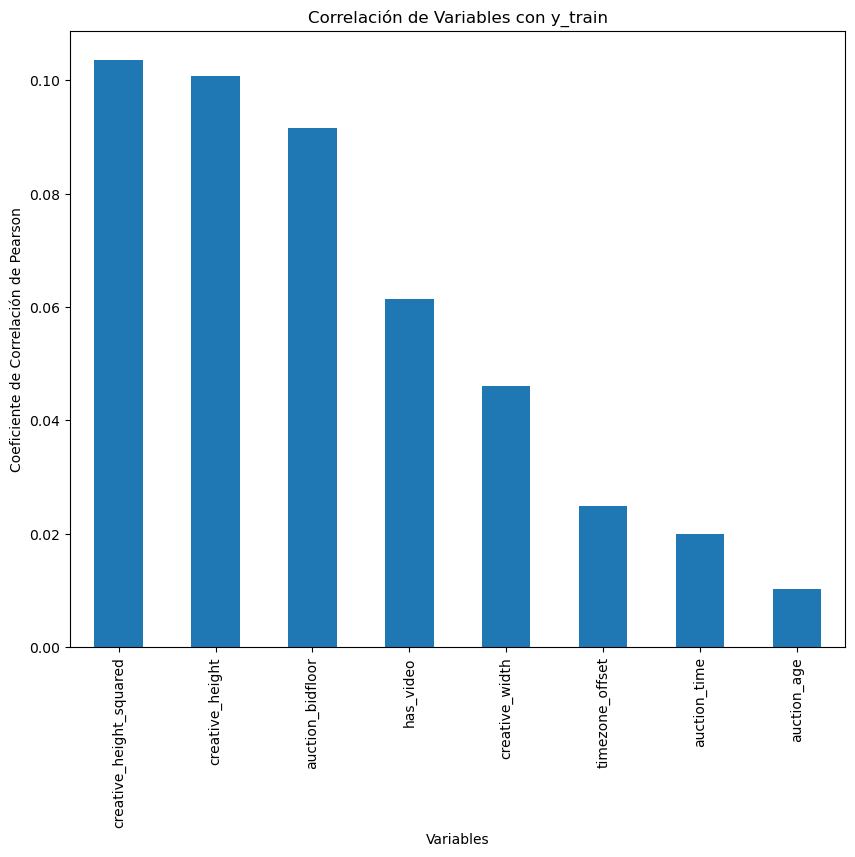

In [19]:
data_with_labels = pd.concat([X_train, y_train], axis=1)

# Calcular la correlación de Pearson entre las características y y_train
correlations = data_with_labels.corr()['Label'].drop('Label')  # Excluir la autocorrelación de 'Label'

# Ordenar las correlaciones de mayor a menor
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Imprimir las correlaciones
print(correlations_sorted)

# Graficar las correlaciones
plt.figure(figsize=(10, 8))
correlations_sorted.plot(kind='bar')
plt.title('Correlación de Variables con y_train')
plt.xlabel('Variables')
plt.ylabel('Coeficiente de Correlación de Pearson')
plt.show()

In [20]:
# Make the submission file
submission_df = pd.DataFrame({"id": eval_data["id"], "Label": y_preds})
submission_df["id"] = submission_df["id"].astype(int)
submission_df.to_csv("xgboost_model8.csv", sep=",", index=False)